# Top 100 Most Subscribed Indonesian Youtubers: Data Scraping

Rafi Naufal Aziz  
2023-10-26

# Background

YouTube has become one of the largest platforms in the world. In
Indonesia itself, YouTube ranks second on the list of the most visited
sites. With such a large audience, YouTube provides a huge opportunity
for anyone looking to pursue a career in content creation.

Certainly, there will be many considerations to be faced before creating
a content. Understanding trends and audience preferences is crucial,
especially on a highly dynamic platform like YouTube.

Therefore, I will attempt to analyze data from the top 100 YouTubers in
Indonesia with the most subscribers. With this analysis, I hope we can
gain insights into what kind of contents are trending in Indonesia and
identify what creators can do to enhance their channel’s potential.

This project is divided into two parts. The first part involves data
collection (scraping) and data cleaning, while the second part involves
data visualization and analysis. The analysis part can be viewed
[here](/posts/youtube_analysis/youtube_analysis.html).

> **Caution**
>
> You might get different result when you run all the code in this
> article. This happens because the data source will be changed (or
> rather, updated) frequently.

# Data Source

## Where and how to collect the data?

To obtain the data, I could have used the YouTube API. However, due to
resource limitations, I ended up using data scraping technique on
[SocialBlade](https://socialblade.com/youtube/top/country/id/mostsubscribed)
website to collect the data.

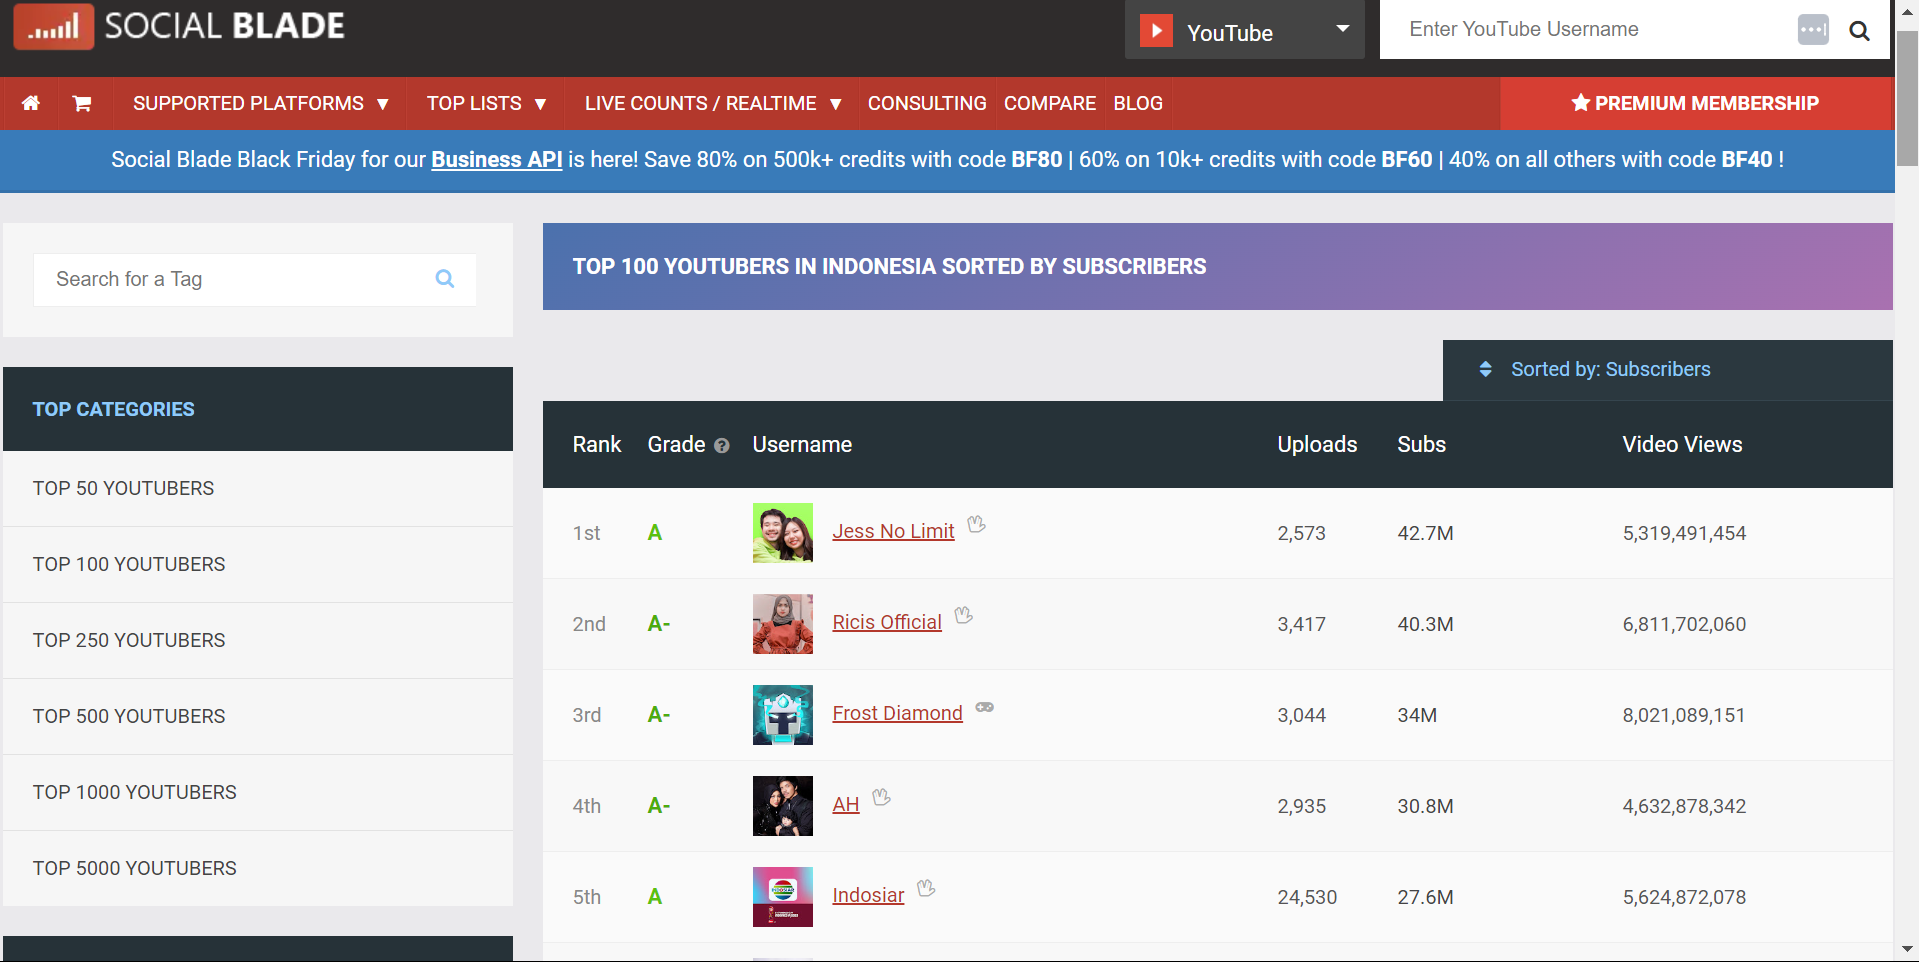

> **Important**
>
> Although all of these data are available publicly and can be accessed
> by anyone, I don’t recommend to do the scraping by yourself, as it is
> against their [terms of service](https://socialblade.com/info/terms).

## What data are we looking for?

We can gather many kinds of data from this website. However, we will
only focus on a few primary pieces of information:

-   Name: The channel’s name
-   Upload count: The number of uploaded content
-   Subscribers: The number of subscribers
-   Views: Total views from all uploaded videos
-   Tag: The main category of the channel
-   Date created: The channel’s creation date
-   Monthly views gained: Number of views gained each month
-   Monthly subs gained: Number of subscribers gained each month

These information are present in each of the channel’s page from the
earlier top 100 list. For example, this one below is from [Jess No
Limit’s](https://socialblade.com/youtube/channel/UCvh1at6xpV1ytYOAzxmqUsA)
page.

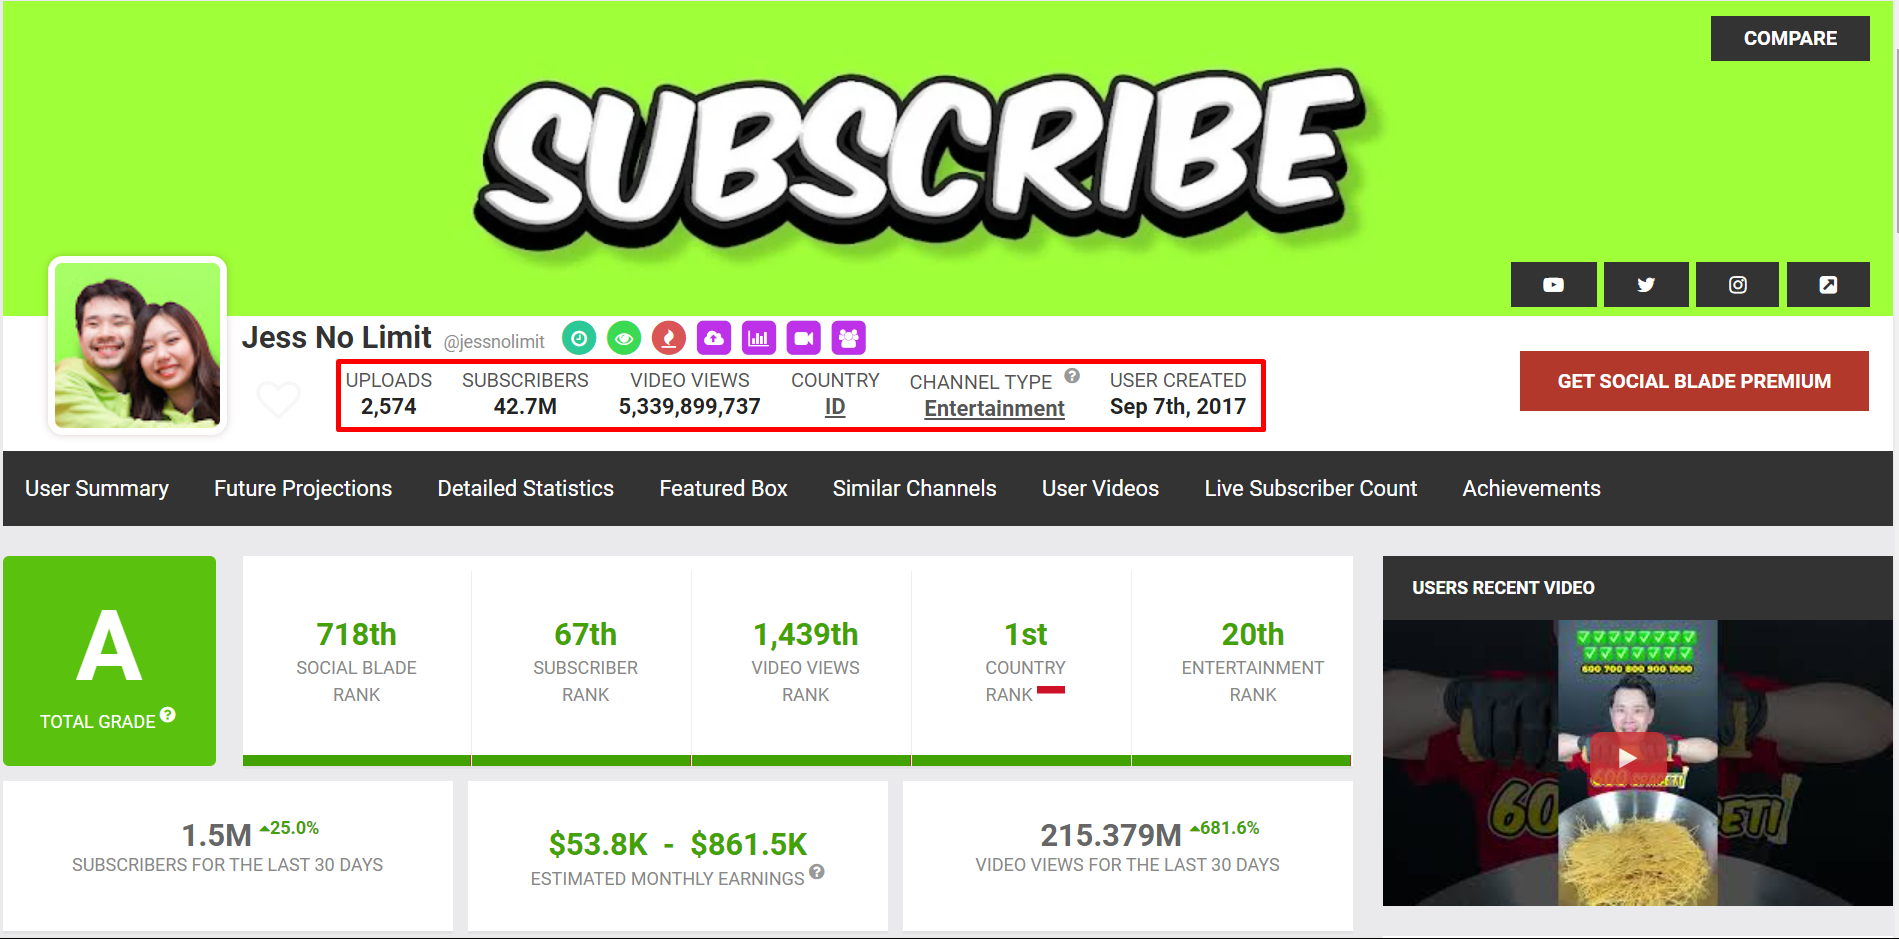

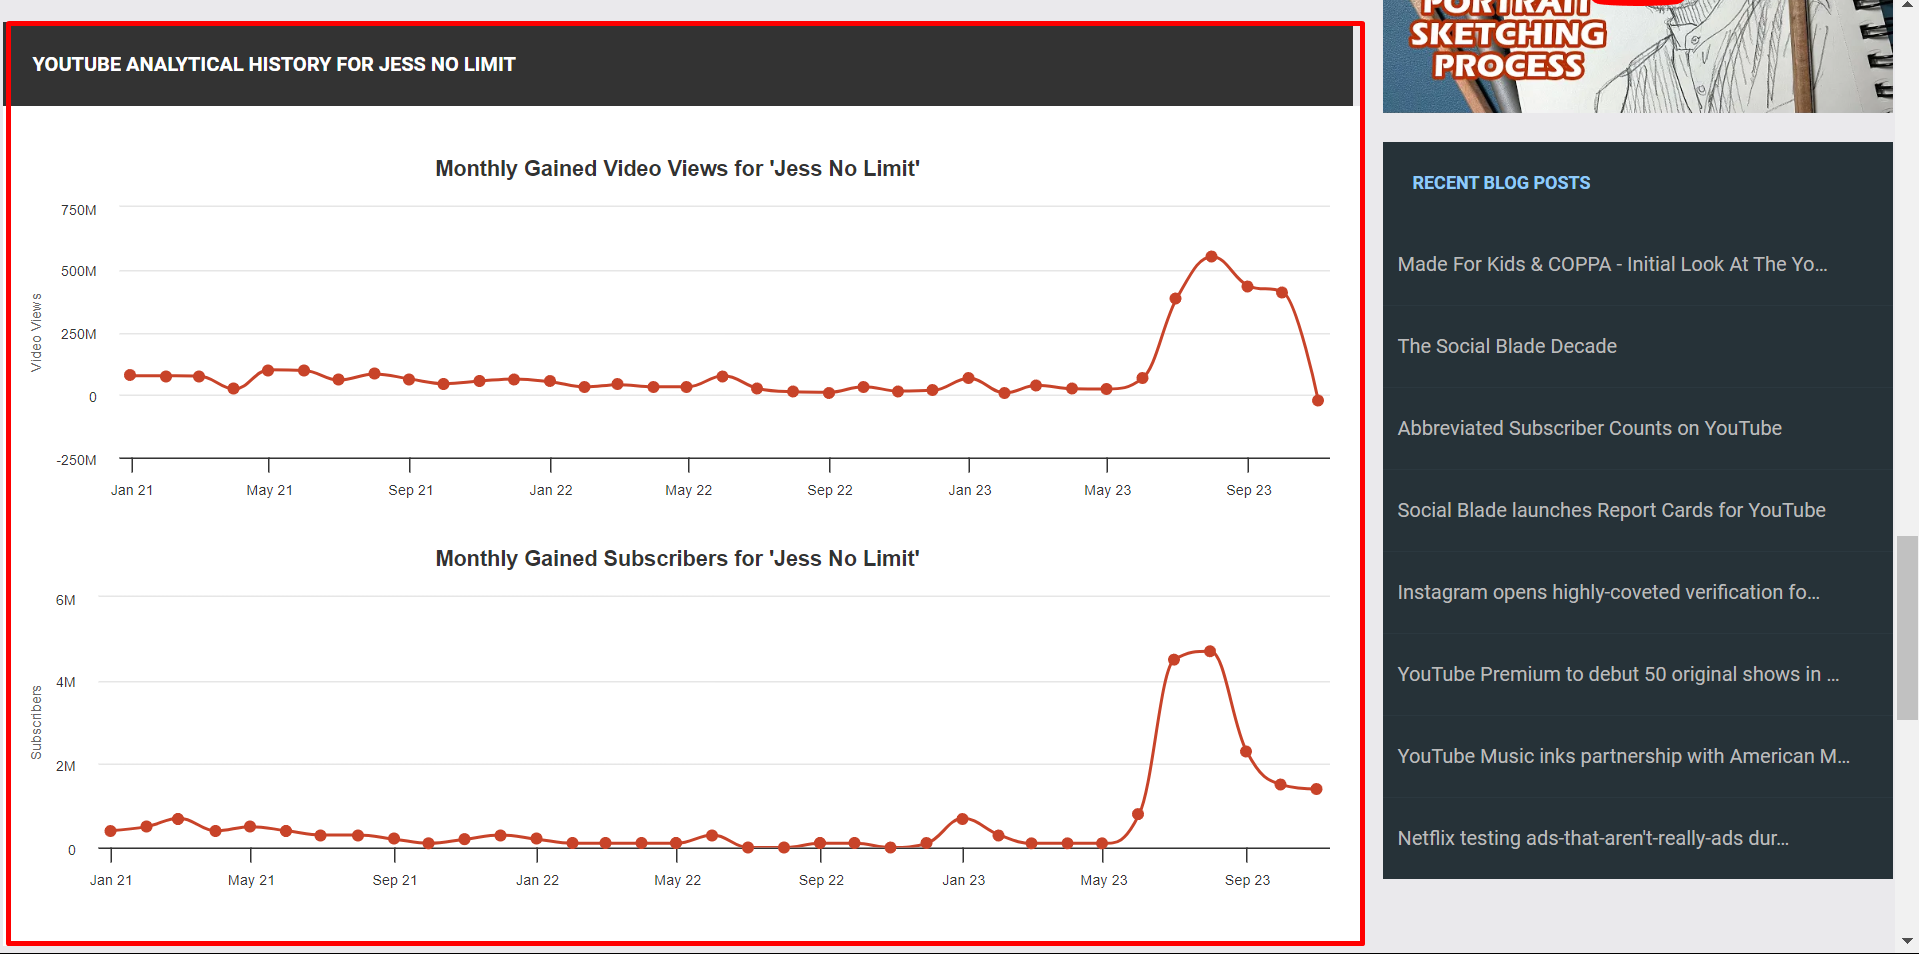

Before we start, let’s import some packages

In [161]:
import json
import re
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
from dateutil.parser import parse

Now let’s begin!

# Data Scraping

## Navigate the top 100 list

First, we will navigate to the main page containing the top 100 most
subscribed Indonesian channels. In Python, we can do this by sending a
request to the URL using `urllib.request` package.

In [106]:
url = 'https://socialblade.com/youtube/top/country/id/mostsubscribed'

# optional, might be needed in some cases
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}

req = Request(url, headers=headers)
response = urlopen(req)

Let’s see if our request was successful (status code 200). If it
succeed, we will create a `soup` variable, which contains the entire
HTML for the URL.

In [107]:
if response.getcode() == 200:
    # parse the HTML content of the page
    soup = bs(response.read(), 'html.parser')
    print('Request success!')

else:
    print(f"Failed to retrieve the page. Status code: {response.getcode()}")

Request success!

Great, we are in! Now, let’s navigate the information page of each
channel on this list. To do that, we need to get the url of each
channel’s page.

## Get each channel’s information page URL

To get the URL of each channel’s page, we need to know where is it
located in the HTML. Apparently, the URL is located in as a `href`
attribute of an `<a>` element inside `<div>` container with attributes
`style="float: left; width: 350px; line-height: 25px;"`. For example,
see the image below. It shows the URL for Jess No Limit’s channel.

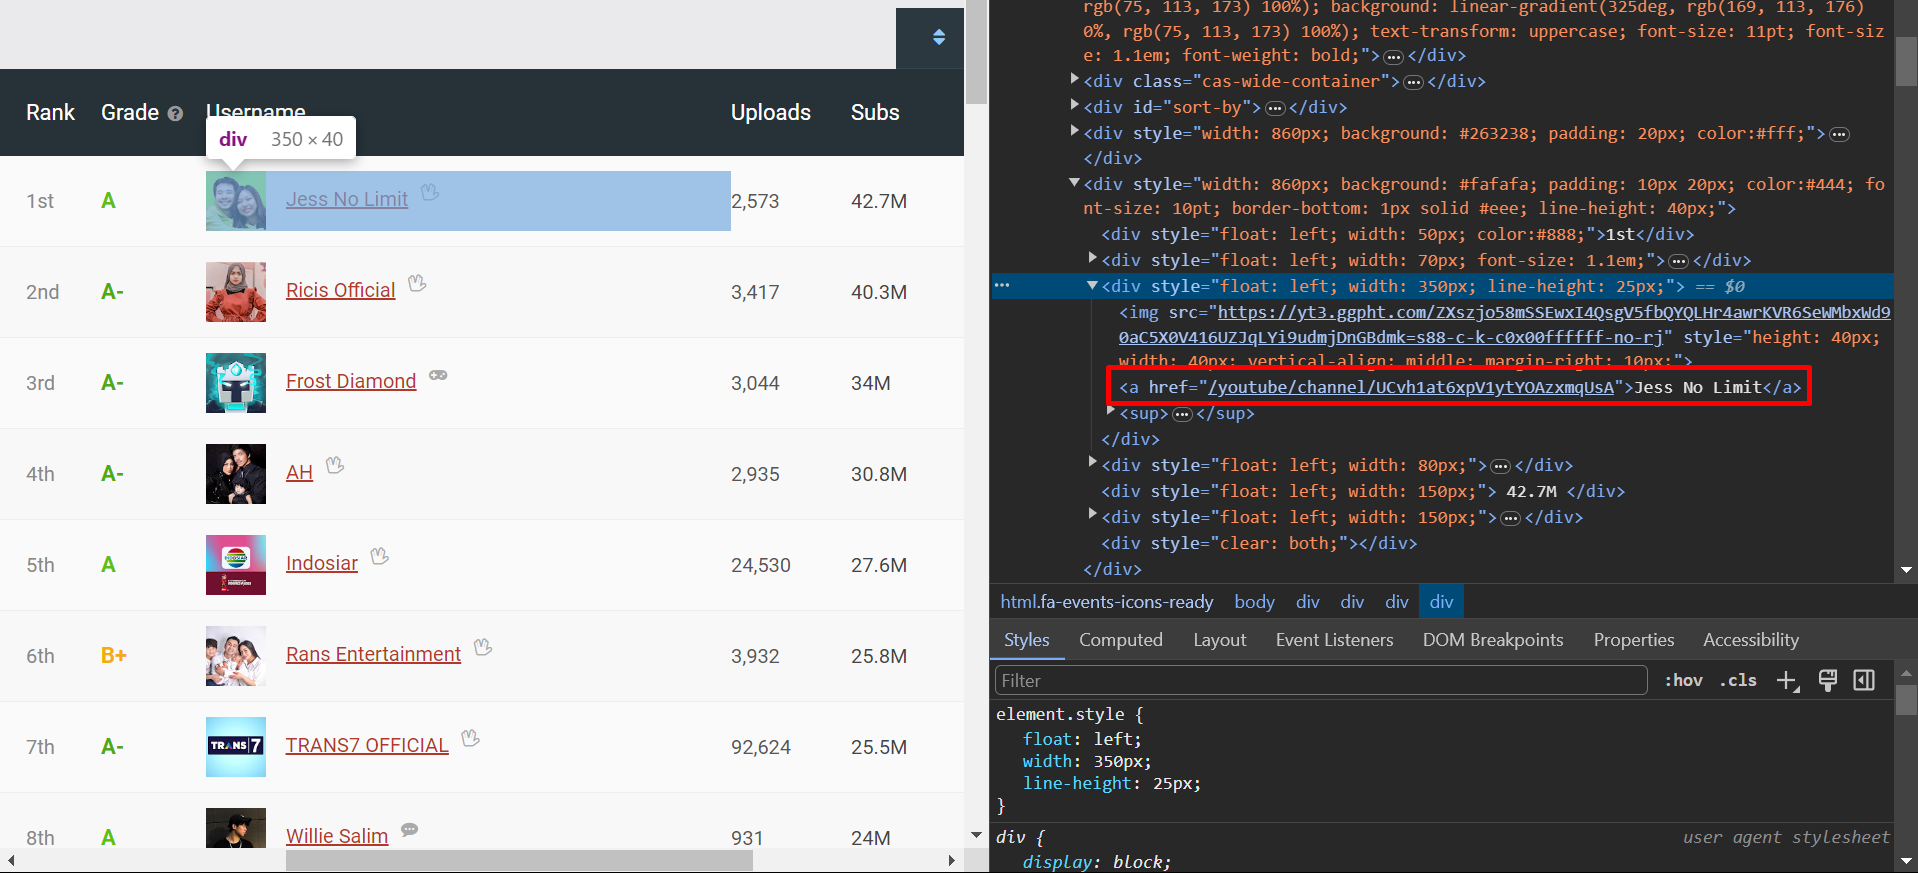

We can retrieve that information easily using `BeautifulSoup`.

In [108]:
# get every div containers that have a specific style attribute
divs_with_style = soup.find_all(
    'div', style="float: left; width: 350px; line-height: 25px;")

# to get each channel's url ID,
# extract value of 'href' attribute in every <a> element inside each div
channel_urls = [div.find('a')['href'] for div in divs_with_style]

# print some example
print('examples:', channel_urls[:3])

examples: ['/youtube/channel/UCvh1at6xpV1ytYOAzxmqUsA', '/youtube/channel/UC4tS4Q_Cno5JVcIUXxQOOpA', '/youtube/channel/UC4hGmH5sABOA70D4fGb8qNQ']

## Navigate information page of each channel

Having acquired the URL for each channel’s information page, we can
access it using a similar procedure to the previous one. For example,
here is how you would access the information page for Jess No Limit’s
channel.

In [109]:
channel_url = 'https://socialblade.com' + '/youtube/channel/UCvh1at6xpV1ytYOAzxmqUsA'

# optional, might be needed in some cases
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}

req = Request(channel_url, headers=headers)
response = urlopen(req)

#| echo: true
if response.getcode() == 200:
    # parse the HTML content of the page
    soup = bs(response.read(), 'html.parser')
    print('Request success!')

else:
    print(f"Failed to retrieve the page. Status code: {response.getcode()}")

Request success!

## Get the data

I will divide this section into two parts, basic data and time series
data. The reason is that their structure is different:

-   Channel’s basic data are one-to-one, meaning that one channel only
    has one combination of basic data (name, subs, views, etc)
-   Channel’s time series data are one-to-many, meaning that one channel
    has multiple monthly information.

### Basic data

#### Name

For name information, it is located in a `<h1>` element with style
`float: left; font-size: 1.4em; font-weight: bold; color:#333; margin: 0px; padding: 0px; margin-right: 5px;`.
For example, see the image below. It shows the name of Jess No Limit’s
channel.

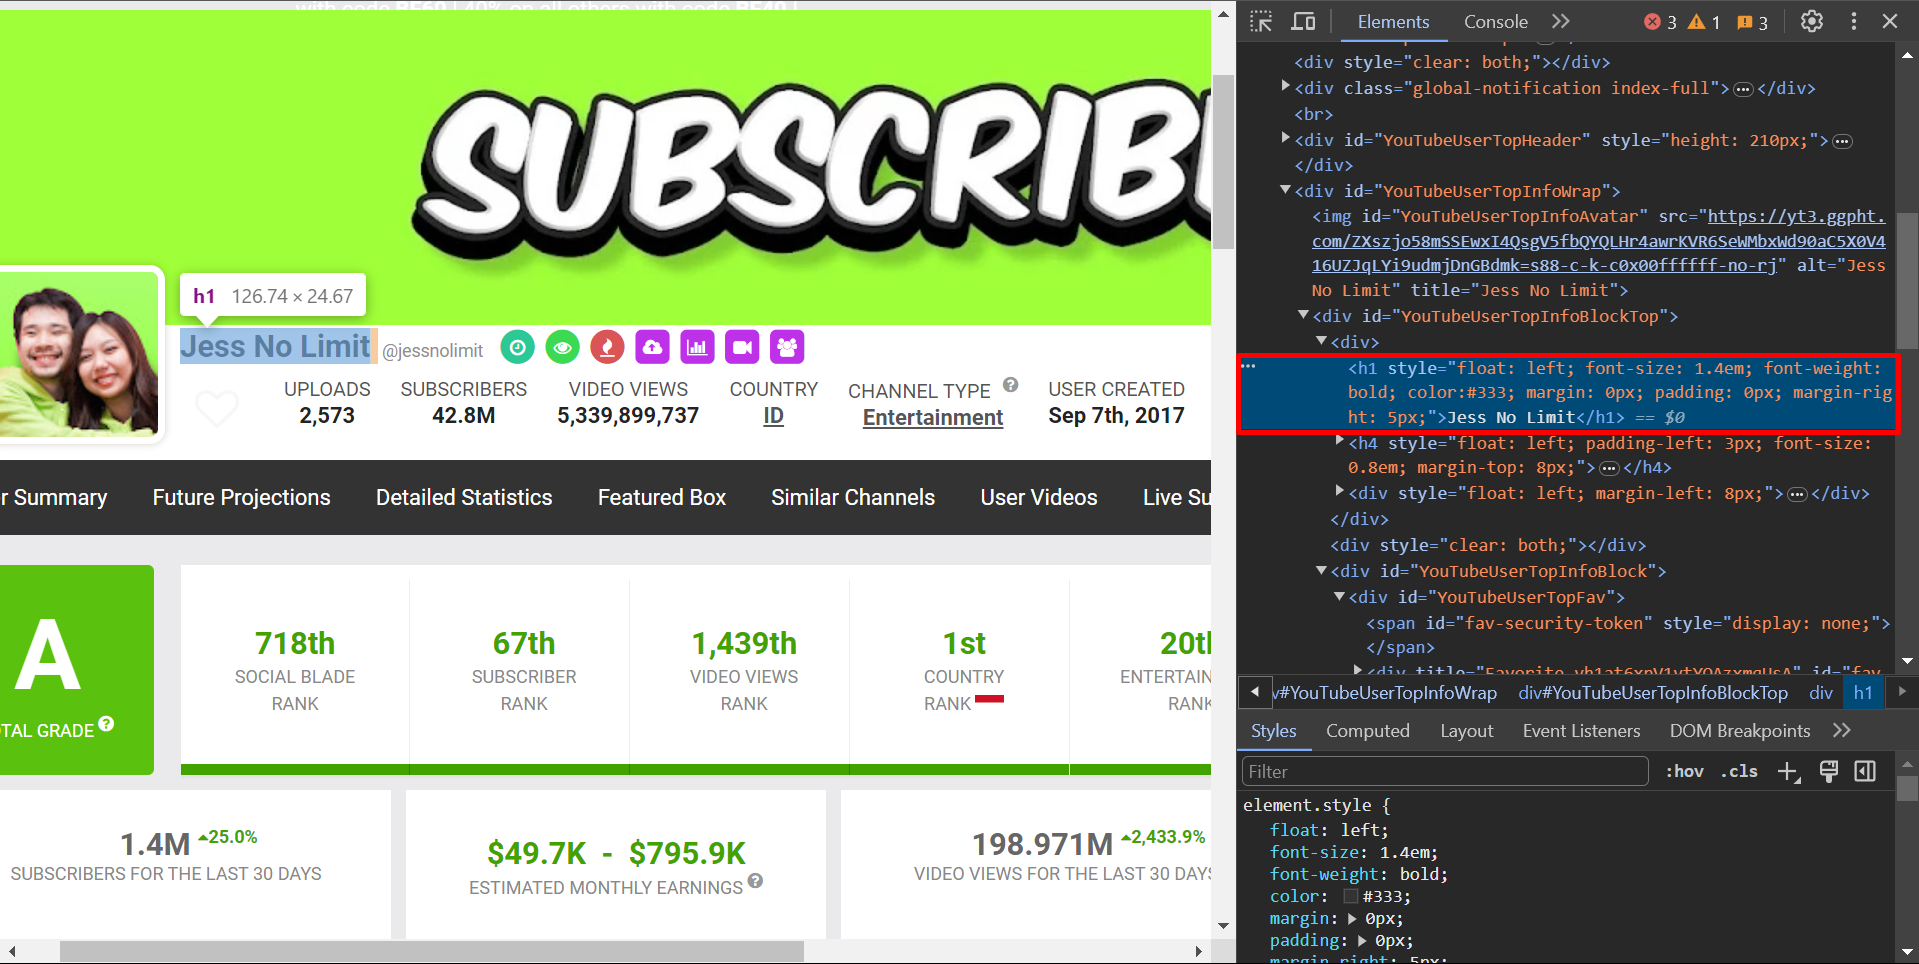

We can retrieve that information like we did before using
`BeautifulSoup`.

In [111]:
# get first <h1> element that have a specific style attribute
name = soup.find(
    'h1', style="float: left; font-size: 1.4em; font-weight: bold; color:#333; margin: 0px; padding: 0px; margin-right: 5px;")

# strip to remove additional spaces
name = name.text.strip()

# print name result
print(f'the name of the channel is {name}.')

the name of the channel is Jess No Limit.

#### Uploads, subs, views, tag, and date

For other basic information, it is located in a `<span>` element with
style `font-weight: bold;`. In addition to that, we have to make sure
that we don’t collect country information, because we already know all
channels that we are going to visit are from Indonesia. Again, as an
example, see the image below.

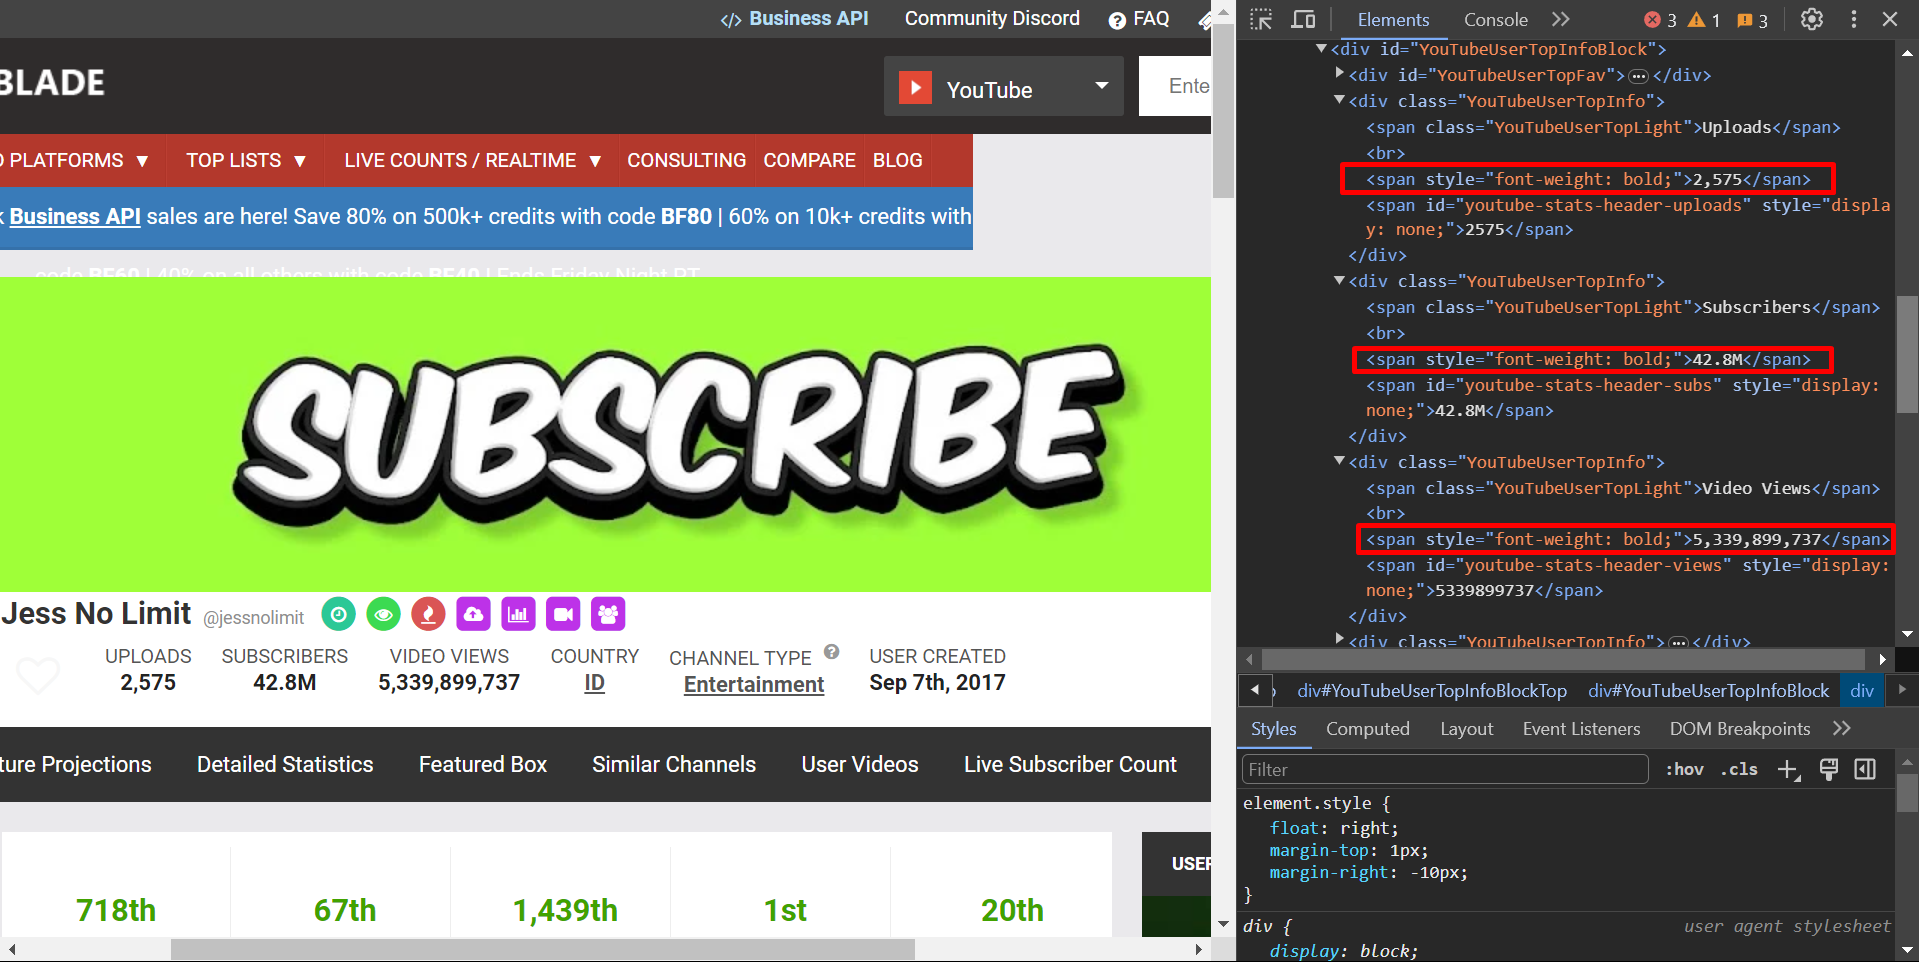

Using similar procedure like before, it yields all the basic data that
we need.

In [112]:
# get first <h1> element that have a specific style attribute
name = soup.find(
    'h1', style="float: left; font-size: 1.4em; font-weight: bold; color:#333; margin: 0px; padding: 0px; margin-right: 5px;")

# strip to remove additional spaces
name = name.text.strip()

# get all <span> elements that have a specific style attribute
spans_with_style = soup.find_all('span', style="font-weight: bold;")
result_basic = [name] + [span.text for span in spans_with_style if span.text != 'ID']

# print name result
print(f'Basic data about this channel: {result_basic}.')

Basic data about this channel: ['Jess No Limit', '2,575', '42.8M', '5,347,533,136', 'Entertainment', 'Sep 7th, 2017'].

### Time series data

Now for time series data, it’s a bit trickier. Since the monthly chart
is interactive, we need to hover to a point to see the number of subs
(or views) gained at that point. This means that the moment we enter
this page, the number isn’t shown up anywhere. Therefore, we should be
looking for the time series data somewhere in the script that’s linked
to that chart.

For example, here’s what the time series data looks like Jess No Limit’s
page.

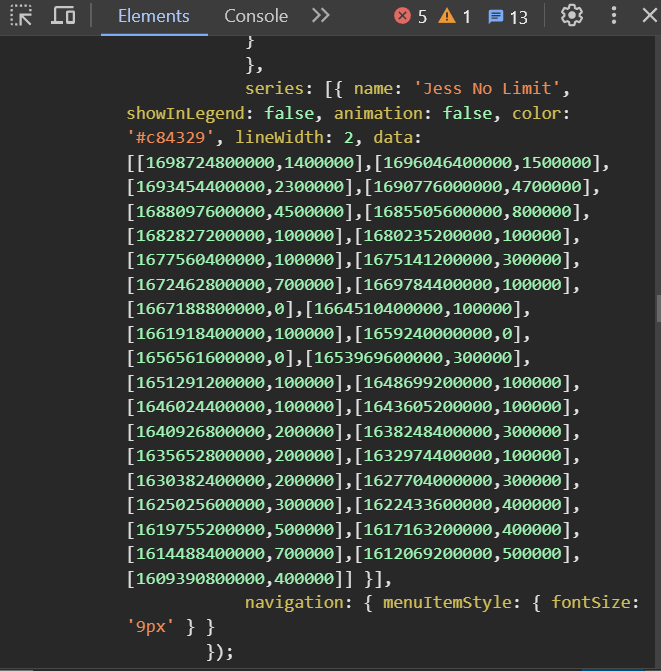

As we can see, it contains a list of list, which each inner list
consists of two elements: first one for ID and second one for the actual
data (in above example, subscribers gained). So how do we find that data
using our program?

First we will find all of the `<script>` element. Let’s see what it
looks like.

In [131]:
# find all <script> element
script = soup.find_all('script')

# merge all found elements to be single text
script = ''.join(str(item) for item in script)

print(f'script elements (first 200 characters): {script[:200]}')

'script elements (first 200 characters): <script type="text/javascript">var _sf_startpt=(new Date()).getTime()</script><script type="text/javascript">var beforeload = (new Date()).getTime()</script><script src="//use.fontawesome.com/64cd5ce7'

Now, in that text, we want to retrieve all part of the text that is in
the form of a 2D list (starts with ‘\[\[’ and ends with ’\]\]’).
Remember that there will be two chunk of text that matches this
criteria: one for monthly gained subs and one for monthly gained views.

In [133]:
# find all part of text that matches this pattern
data = re.findall(r'data:\s*(\[\[.*?\]\])', script)

# we use json.loads here to convert the text into a list
subs_data = json.loads(data[0])
views_data = json.loads(data[1])

print(f'subs data: {subs_data}\n')
print(f'views data: {views_data}')

subs data: [[1698724800000,1400000],[1696046400000,1500000],[1693454400000,2300000],[1690776000000,4700000],[1688097600000,4500000],[1685505600000,800000],[1682827200000,100000],[1680235200000,100000],[1677560400000,100000],[1675141200000,300000],[1672462800000,700000],[1669784400000,100000],[1667188800000,0],[1664510400000,100000],[1661918400000,100000],[1659240000000,0],[1656561600000,0],[1653969600000,300000],[1651291200000,100000],[1648699200000,100000],[1646024400000,100000],[1643605200000,100000],[1640926800000,200000],[1638248400000,300000],[1635652800000,200000],[1632974400000,100000],[1630382400000,200000],[1627704000000,300000],[1625025600000,300000],[1622433600000,400000],[1619755200000,500000],[1617163200000,400000],[1614488400000,700000],[1612069200000,500000],[1609390800000,400000]]

views data: [[1698724800000,-19801666],[1696046400000,411397220],[1693454400000,435506366],[1690776000000,551439344],[1688097600000,386627362],[1685505600000,65763364],[1682827200000,23496055

Next, we will filter the relevant numbers and put them together into a
pair of \[subs, views\] for each months.

In [134]:
# find all part of text that matches this pattern
data = re.findall(r'data:\s*(\[\[.*?\]\])', script)

# we use json.loads here to convert the text into a list
subs_data = json.loads(data[0])
views_data = json.loads(data[1])

result_time_series = []

# filter it by grabbing the second value,
# and put them together in `result` variable
for subs, views in zip(subs_data, views_data):
    result_time_series.append([subs[1], views[1]])
    
print(f'result: {result_time_series}')

result: [[1400000, -19801666], [1500000, 411397220], [2300000, 435506366], [4700000, 551439344], [4500000, 386627362], [800000, 65763364], [100000, 23496055], [100000, 24277175], [100000, 38229401], [300000, 8254410], [700000, 66544745], [100000, 18234562], [0, 15043919], [100000, 32917405], [100000, 10335789], [0, 12288453], [0, 25526169], [300000, 76262949], [100000, 32441094], [100000, 32631614], [100000, 40522486], [100000, 31444275], [200000, 52438812], [300000, 63853960], [200000, 55090234], [100000, 44384186], [200000, 62924763], [300000, 83710454], [300000, 59117171], [400000, 97490812], [500000, 99810016], [400000, 23185815], [700000, 75239628], [500000, 76170914], [400000, 76419152]]

So, Jess No Limit gained 1400000 subs and lost 19801666 views in last
month (October 2023).

> **Note**
>
> A channel can lose views count due to some of their videos were
> deleted by youtube or by themself.

## Putting it all together

Let’s put it all together and make some functions!

-   `get_channel_data` returns informations from each channels
-   `get_all_data`basically calls `get_channel_data` on every channels
    and return all of the informations collected from each of them.

In [145]:
def get_channel_data(channel_url, headers=None):
    channel_url = 'https://socialblade.com' + channel_url
    # send a request to the channel URL
    req = Request(channel_url, headers=headers)
    response = urlopen(req)

    # check if the request was successful (status code 200)
    if response.getcode() == 200:
        soup = bs(response.read(), 'html.parser')

        # basic
        name = soup.find(
            'h1', style="float: left; font-size: 1.4em; font-weight: bold; color:#333; margin: 0px; padding: 0px; margin-right: 5px;")
        name = name.text.strip()

        spans_with_style = soup.find_all('span', style="font-weight: bold;")
        result_basic = [name] + \
                       [span.text for span in spans_with_style if span.text != 'ID']

        # time series
        script = soup.find_all('script')
        script = ''.join(str(item) for item in script)

        data = re.findall(r'data:\s*(\[\[.*?\]\])', script)
        subs_data = json.loads(data[0])
        views_data = json.loads(data[1])

        result_time_series = []

        for subs, views in zip(subs_data, views_data):
            result_time_series.append([subs[1], views[1]])

        return result_basic, result_time_series

    else:
        return(f"Failed to retrieve the page. Status code: {response.getcode()}")


def get_all_data(url, headers=None):

    req = Request(url, headers=headers)
    response = urlopen(req)
    
    if response.getcode() == 200:

        soup = bs(response.read(), 'html.parser')
        divs_with_style = soup.find_all(
            'div', style="float: left; width: 350px; line-height: 25px;")
        channel_urls = [div.find('a')['href'] for div in divs_with_style]

        # results
        result_basic = []
        result_time_series = []

        for channel_url in channel_urls:
            # get result of each channels and append it to the results
            channel_result_basic, channel_result_time_series = get_channel_data(
                channel_url, headers=headers)

            result_basic.append(channel_result_basic)
            result_time_series.append(channel_result_time_series)

            # (optional) add a sleep to prevent requests sent too fast
            time.sleep(0.1)

        return result_basic, result_time_series

    else:
        return(f"Failed to retrieve the page. Status code: {response.getcode()}")

You can execute the code below to call the function and store the data
in `data_basic` and `data_time_series`.

In [146]:
url = 'https://socialblade.com/youtube/top/country/id/mostsubscribed'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}

data_basic, data_time_series = get_all_data(url, headers)

# Data Cleaning

## Basic data

### Examine the data

It will be convenient to clean the data before we proceed to analyze it.
Let’s examine what can we do to make our data cleaner. First, let’s
create a dataframe and ask: What does the data looks like? Do each
column have a proper data type?

In [149]:
df_1 = pd.DataFrame(data_basic,
             columns=['name', 'upload_count', 'subscribers (million)', 'views', 'tag', 'date_created'])
df_1

100 rows × 6 columns

In [150]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   100 non-null    object
 1   upload_count           100 non-null    object
 2   subscribers (million)  100 non-null    object
 3   views                  100 non-null    object
 4   tag                    100 non-null    object
 5   date_created           100 non-null    object
dtypes: object(6)
memory usage: 4.8+ KB

There are several problems that we can fix here:

1.  `upload_count`, `subscribers (million)`, and `views` should be
    integer, not object
2.  `date_created` should be datetime, not object

### Convert column dtype

Before converting `upload_count` and `views` column into an integer
column, we should remove the comma separator in each of the entry. We
can do that by replacing (instead of removing) these commas with an
empty string using
[`str.replace()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html).

For `subscribers (million)`, we replace the ‘M’ letter with an empty
string.

In [152]:
df_1['upload_count'] = df_1['upload_count'].str.replace(',', '')
df_1['views'] = df_1['views'].str.replace(',', '')
df_1['subscribers (million)'] = df_1['subscribers (million)'].str.replace('M', '')

Then, we can convert them easily using
[`astype()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html)

In [154]:
df_1 = df_1.astype({
    'upload_count': 'int',
    'subscribers (million)': 'float',
    'views': 'int64',
})

For the `date_created` column, we will also use `astype` to convert it
into a datetime object. However, pandas won’t immediately recognize the
format (like “Sep 7th, 2017”) as a date.

This is where `parse`, one of the functions that we imported at the
beginning, comes in handy. That function will reformat our date value
into a format that `astype` would recognize. For example, it would
transform “Sep 7th, 2017” into “2017-09-07”.

We can utilize the method `apply()` To implement `parse` for each value
in a dataframe column.

In [163]:
df_1['date_created'] = df_1['date_created'].apply(parse).astype('datetime64[ns]')

Let’s check how our dtypes looks like now.

In [165]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   100 non-null    object        
 1   upload_count           100 non-null    int32         
 2   subscribers (million)  100 non-null    float64       
 3   views                  100 non-null    int64         
 4   tag                    100 non-null    object        
 5   date_created           100 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(2)
memory usage: 4.4+ KB

### Add some features

Although we have enough features to begin with, it still can be
improved. I can think of two new features to be added.

1.  `views/upload_count`: with this new feature, it can tells us the
    efficiency of a channel in terms of viewers per video. It makes
    comparing the performance of two channels easier.
2.  `age`: to intuitively quantify `date_created` column into an integer
    value.

In [167]:
df_1['views/video'] = df_1['views']/(df_1['upload_count'])
now = pd.Timestamp('now')
df_1['age'] = round((now - df_1['date_created']).dt.days / 365, 1)

In [168]:
df_1

100 rows × 8 columns

## Time series data

For time series data, each channel must have exacly 35 months (3 years)
of record, meaning that there will be 100 x 35 rows in the dataframe.

However, some channels might be created within the last three years and
having less than 35 months of record. In this case, we will append zero
values to the record for each months where the channels haven’t been
created.

Some channels might also have more than 35 months for some reason (maybe
it already contains the record for this month), so we will delete the
last record in this case.

In [171]:
# make 35 rows of each names
names = df_1['name']
new_names = []
for name in names:
    new_names.extend([name]*35)

subs_gained = []
views_gained = []
for element in data_time_series:
    n = len(element)
    
    # if it is less than 35 records, append a [0, 0] values to the record
    if n < 35:
        extender = [[0, 0] for i in range(35-n)]
        element.extend(extender)
        
    # if it is more than 35 records, remove the last record
    elif n > 35:
        element.pop()
    
    # separate subs and views information from the record    
    for subs, views in element:
        subs_gained.append(subs)
        views_gained.append(views)

Let’s see how the dataframe looks like

In [173]:
df_2 = pd.DataFrame({
    'name': new_names,
    'views_gained': views_gained,
    'subs_gained': subs_gained,
})

df_2

3500 rows × 3 columns

I think we forgot something: the date! There should be a date column
that indicates when the views and subs were gained. Because I do this
analysis in November, we will create a 35 months range from December
2020 to October 2023 for each channel.

In [177]:
# create a monthly date range from dec 2020 to oct 2020
dates = pd.Series(pd.date_range('2020-12','2023-10', 
              freq='MS'))[::-1]

# we multiply it by 100 (the number of channels)
dates = pd.concat([dates]*100, ignore_index=True)

df_2['date'] = dates

df_2

3500 rows × 4 columns

## Merge the two dataframes

Last but not least, merge the two dataframes together to get our final,
clean dataframe. This dataframe will be used for visualization and
analysis in the [next
part](posts/youtube_analysis/youtube_analysis.html).

In [179]:
df = pd.merge(df_1, df_2, left_on='name', right_on='name')
df

3500 rows × 11 columns